In [1]:
import numpy as np 
import pandas as pd 
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image

In [6]:
from glob import glob
data = glob('/kaggle/input/breast-histopathology-images/**/*.png', recursive=True)

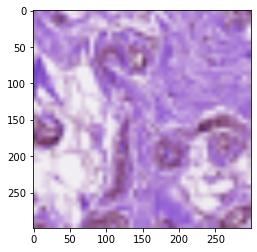

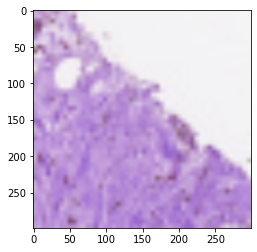

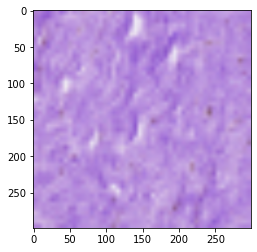

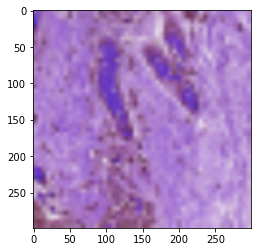

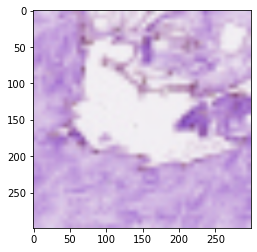

In [7]:
import cv2
import matplotlib.pyplot as plt
for i in data[:5]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(299,299))
    plt.imshow(img_1,cmap='binary')
    plt.show()

In [8]:
print(len(data))

555048


In [13]:
images=[]
labels=[]
for i in data[:1500]:
    if i.endswith('.png'):
        label=i[-5]
        img=cv2.imread(i)
        img_1=cv2.resize(img,(299, 299))
        images.append(img_1)
        labels.append(label)

In [14]:
x=np.stack(images)

In [15]:
print(x.shape)

(1500, 299, 299, 3)


In [16]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(labels)

In [17]:
#normalize the data
x=x/255

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)

In [19]:
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers

In [20]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, \
     Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D

def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3)
    tensor = ReLU()(x)

    x = sep_bn(tensor, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=128, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=256, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=728, kernel_size=1, strides=2)
    x = Add()([tensor, x])

    return x


def middle_flow(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)

        tensor = Add()([tensor, x])

    return tensor


def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size=3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=1024, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = sep_bn(x, filters=1536, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size=3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(units=2, activation='softmax')(x)

    return x


input = Input(shape=[299, 299, 3])

x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

from tensorflow.keras import Model 
model = Model(input, output)

In [21]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])

In [22]:
y_train = np.array(y_train)

In [24]:
history = model.fit(x_train, y_train, epochs=20, validation_split=0.4, batch_size=16)

Epoch 1/20
45/45 [==============================] - 21s 461ms/step - loss: 0.1221 - acc: 0.9556 - val_loss: 0.6399 - val_acc: 0.8854
Epoch 2/20
45/45 [==============================] - 20s 434ms/step - loss: 0.1124 - acc: 0.9639 - val_loss: 0.6237 - val_acc: 0.8854
Epoch 3/20
45/45 [==============================] - 20s 434ms/step - loss: 0.0945 - acc: 0.9694 - val_loss: 0.6072 - val_acc: 0.8854
Epoch 4/20
45/45 [==============================] - 19s 432ms/step - loss: 0.0878 - acc: 0.9722 - val_loss: 0.5838 - val_acc: 0.8854
Epoch 5/20
45/45 [==============================] - 20s 434ms/step - loss: 0.0840 - acc: 0.9708 - val_loss: 0.5578 - val_acc: 0.8854
Epoch 6/20
45/45 [==============================] - 20s 435ms/step - loss: 0.0660 - acc: 0.9819 - val_loss: 0.5320 - val_acc: 0.8854
Epoch 7/20
45/45 [==============================] - 20s 434ms/step - loss: 0.0621 - acc: 0.9819 - val_loss: 0.4952 - val_acc: 0.8854
Epoch 8/20
45/45 [==============================] - 20s 435ms/step - 

In [25]:
history = model.fit(x_train, y_train, epochs=20, validation_split=0.4, batch_size=32)

Epoch 1/20
23/23 [==============================] - 19s 838ms/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.1116 - val_acc: 0.9563
Epoch 2/20
23/23 [==============================] - 18s 802ms/step - loss: 0.0062 - acc: 0.9986 - val_loss: 0.1106 - val_acc: 0.9563
Epoch 3/20
23/23 [==============================] - 19s 806ms/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.1406 - val_acc: 0.9542
Epoch 4/20
23/23 [==============================] - 18s 801ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.1086 - val_acc: 0.9563
Epoch 5/20
23/23 [==============================] - 19s 807ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.1048 - val_acc: 0.9563
Epoch 6/20
23/23 [==============================] - 19s 804ms/step - loss: 0.0043 - acc: 0.9986 - val_loss: 0.1070 - val_acc: 0.9563
Epoch 7/20
23/23 [==============================] - 18s 804ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.1182 - val_acc: 0.9583
Epoch 8/20
23/23 [==============================] - 18s 803ms/step - 

In [ ]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.4, batch_size=64)

In [30]:
loss, accuracy = model.evaluate(x_test,y_test)

10/10 [==============================] - 1s 140ms/step - loss: 0.0957 - acc: 0.9800


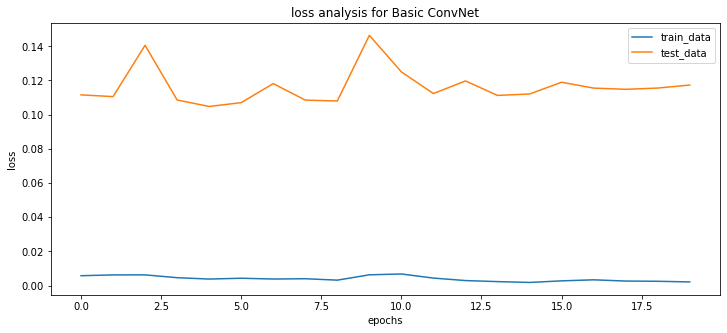

In [31]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data','test_data'])
plt.title('loss analysis for Basic ConvNet')
plt.show()

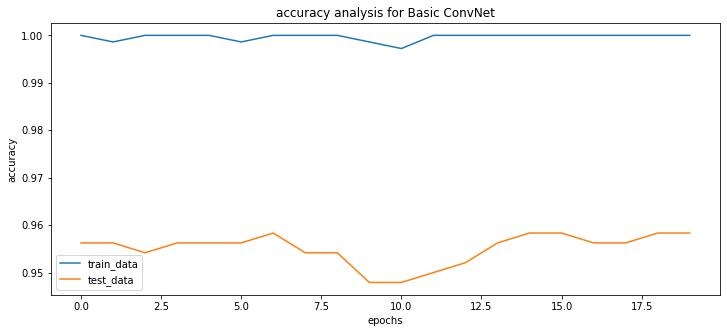

In [32]:
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data','test_data'])
plt.title('accuracy analysis for Basic ConvNet')
plt.show()